In [1]:
from module import *
from tool import *
from test import *
from IPython.display import clear_output
from copy import deepcopy as dc
from tqdm import tqdm
import os

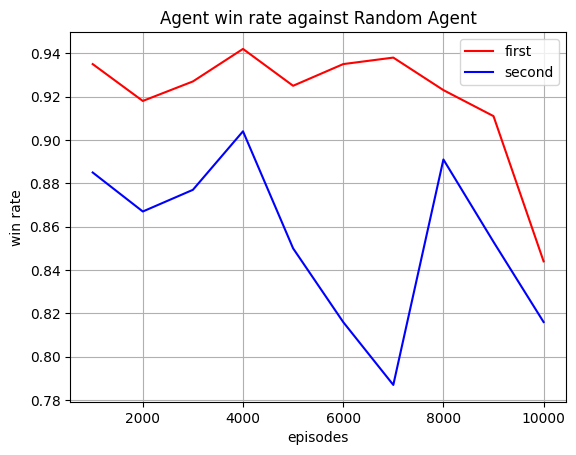

In [2]:
env = ConnectFourEnvironment()
input_size = 6 * 7
output_size = 7 
agent = DQNAgent(input_size, output_size)

model_path = f"main10000V2/"
os.makedirs(model_path, exist_ok=True)

num_episodes = 10000
start_epsilon = 0.5
end_epsilon = 0.05

target_update_frequency = 100
save_model_frequency = 1000
clear_memory_frequency = 1000
threshold_episodes_save = 1000

results = []

for episode in tqdm(range(num_episodes)):
    state = env.get_state()
    done = False
    epsilon = start_epsilon - episode * (start_epsilon - end_epsilon) / num_episodes
    episodeplus = episode + 1
        
    while not done:
        prev_state = dc(state)
        action = agent.select_action(state, env, epsilon)
        next_state, reward, done = env.step(action)
        current_state = dc(next_state)
        agent.store_transition(Transition(prev_state, action, current_state, reward))
        state = next_state
        # env.display_board()
    
    agent.train()
    

    if episodeplus % target_update_frequency == 0:
        agent.update_target_network()
        
    if episodeplus % clear_memory_frequency == 0:
        agent.memory.clear()
        
    if episodeplus % save_model_frequency == 0:
        if episodeplus >= threshold_episodes_save: torch.save(agent.policy_net.state_dict(), os.path.join(model_path, f"{episodeplus}.pth"))
        f, s = TestCase01(agent, 2000)
        results.append((episode + 1, f, s))
        clear_output(wait=True)
        update_plot(results)
        
    env.reset()
    
    
clear_output(wait=True)
update_plot(results, os.path.join(model_path, "results.png"))
open(os.path.join(model_path, "results.txt"), "w").write(str(results))
torch.save(agent.policy_net.state_dict(), "main.pth")